<a href="https://colab.research.google.com/github/sbalram123/CoronaBatch-Session4/blob/master/SB_CoronaBatch_A5C1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Target : 
# 99.4% (this must be consistently shown in your last few epochs, and not a one-time achievement)
# Less than or equal to 15 Epochs
# Less than 10000 Parameters

# We start by adapating our previous submission which had the following parameters 
# Batchnormalization , Dropout , 15,706 paramters and 20 epochs and it hits 99.4 % once in a while 
# Integrate with vizualizations and charts to diagnose the problem of this neural network


# Result :
# Parameters: 15.7k
# Best Train Accuracy: 99.0 (epoch 13)
# Best Test Accuracy: 99.27 (epoch 14)


# Analysis : The gain made by the network in the first epoch is around 98.2% which should be higher in order to hit 99.4% within 15 epochs.
#            So we need to reduce the number of parameters to meet the new target requirement. 
#            Training accuracy never hits 100% . Which means that we need to make some changes in the architechture .



In [0]:
# The gods
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


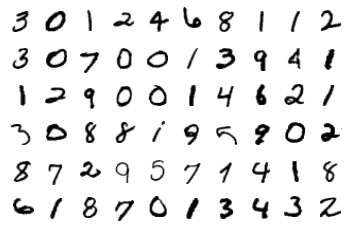

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 100
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1),
                                   nn.Dropout2d(0.15),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(),
                                   nn.Conv2d(16, 32, 3, padding=1),
                                   nn.Dropout2d(0.1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2),
                                   nn.ReLU(),
                                   nn.Conv2d(32, 16, 3),
                                   nn.Dropout2d(0.1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU(),
                                   nn.Conv2d(16, 16, 3),
                                   nn.Dropout2d(0.1),
                                   nn.BatchNorm2d(16),
                                   nn.MaxPool2d(2, 2),
                                   nn.ReLU(),
                                   nn.Conv2d(16, 16, 3),
                                   nn.Dropout2d(0.05),
                                   nn.BatchNorm2d(16),
                                   nn.Conv2d(16, 10, 3))

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         Dropout2d-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
              ReLU-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]           4,640
         Dropout2d-6           [-1, 32, 28, 28]               0
       BatchNorm2d-7           [-1, 32, 28, 28]              64
              ReLU-8           [-1, 32, 28, 28]               0
         MaxPool2d-9           [-1, 32, 14, 14]               0
             ReLU-10           [-1, 32, 14, 14]               0
           Conv2d-11           [-1, 16, 12, 12]           4,624
        Dropout2d-12           [-1, 16, 12, 12]               0
      BatchNorm2d-13           [-1, 16, 12, 12]              32
             ReLU-14           [-1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


KPS	Input	Output	RF	Jout
0	0	28	1	1
3 1 1	28	28	3	1
311	28	28	5	1
202	28	14	6	1
301	14	12	10	2
301	12	10	14	2
202	10	5	16	2
301	5	3	24	4
301	3	1	32	4


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.09483181685209274 Batch_id=468 Accuracy=93.40: 100%|██████████| 469/469 [00:10<00:00, 45.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0556, Accuracy: 9824/10000 (98.24%)

EPOCH: 1


Loss=0.030482903122901917 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:10<00:00, 46.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9852/10000 (98.52%)

EPOCH: 2


Loss=0.0683683380484581 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:10<00:00, 46.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9889/10000 (98.89%)

EPOCH: 3


Loss=0.014855925925076008 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:09<00:00, 47.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9905/10000 (99.05%)

EPOCH: 4


Loss=0.03325866535305977 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:09<00:00, 47.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.023968679830431938 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:10<00:00, 46.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9902/10000 (99.02%)

EPOCH: 6


Loss=0.026831939816474915 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:09<00:00, 47.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9913/10000 (99.13%)

EPOCH: 7


Loss=0.020140433683991432 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:09<00:00, 47.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9907/10000 (99.07%)

EPOCH: 8


Loss=0.025480875745415688 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:09<00:00, 47.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9911/10000 (99.11%)

EPOCH: 9


Loss=0.01507482398301363 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:09<00:00, 48.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.006742904428392649 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:09<00:00, 47.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.03907604143023491 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:09<00:00, 48.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.030316686257719994 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:09<00:00, 47.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss=0.005766322370618582 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:09<00:00, 47.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.041111260652542114 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:09<00:00, 48.24it/s]



Test set: Average loss: 0.0231, Accuracy: 9927/10000 (99.27%)



Text(0.5, 1.0, 'Test Accuracy')

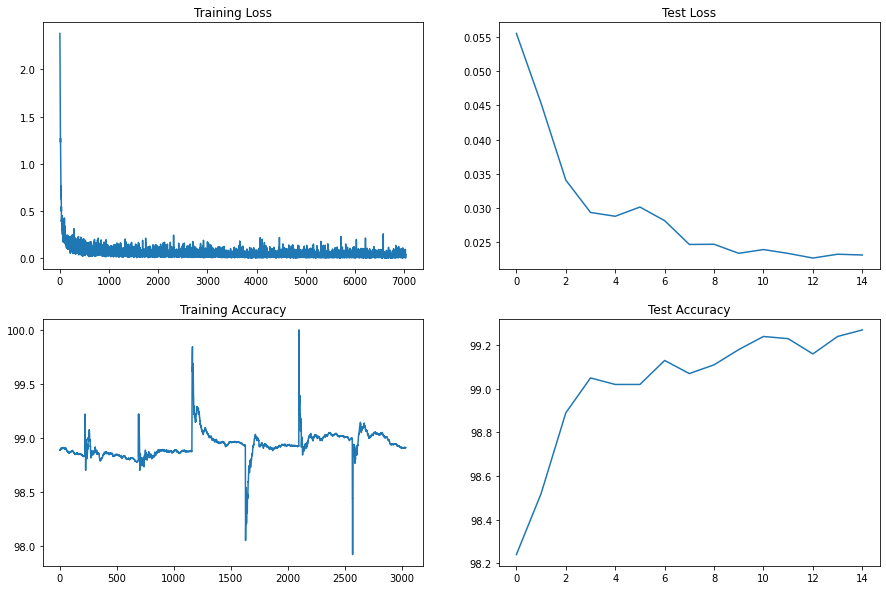

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")